# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:

Данные геологоразведки трёх регионов находятся в файлах: 
1. `geo_data_0.csv`
2. `geo_data_1.csv`
3. `geo_data_2.csv`

Разметка данных:
- `id` — уникальный идентификатор скважины;

- `f0, f1, f2` — три признака точек;

- `prodict` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [32]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [33]:
import pandas as pd
import numpy as np
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

In [34]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

### Исследовательский анализ

In [35]:
def describe_my_data(data, target='product'):
    print('Общая информация:', end='\n\n')
    print(data.info(), end='\n\n')
    print(f'Количество явных дубликатов - {data.duplicated().sum()}', end='\n\n')
    print('Количество пропусков:')
    print(data.isna().sum(), end='\n\n')
    print(f'Количество дубликатов в столбце id: {data["id"].duplicated().sum()}', end='\n\n')
    print('Коэффициенты корреляции:')
    print(data.corr(), end='\n\n')

#### 1-й регион

In [36]:
df1.sample(5)

,id,f0,f1,f2,product
52081,MNZF6,1.546603,-0.293872,0.933250,103.921562
62830,820ZB,1.166424,-0.554926,-1.005735,74.984568
82044,Kl3ar,0.779513,-0.507740,2.287941,156.367237
84288,67u5A,1.926676,-0.043718,9.830568,133.413756
21990,DjrPD,0.388324,-0.287959,2.373021,106.946413


In [37]:
describe_my_data(df1)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество явных дубликатов - 0

Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов в столбце id: 10

Коэффициенты корреляции:
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000



In [38]:
df1.id.duplicated().sum()

10

Удаляем дубликаты в столбйе `id`

In [39]:
df1 = df1.drop_duplicates(['id'])
df1.id.duplicated().sum()

0

Распределение признаков:


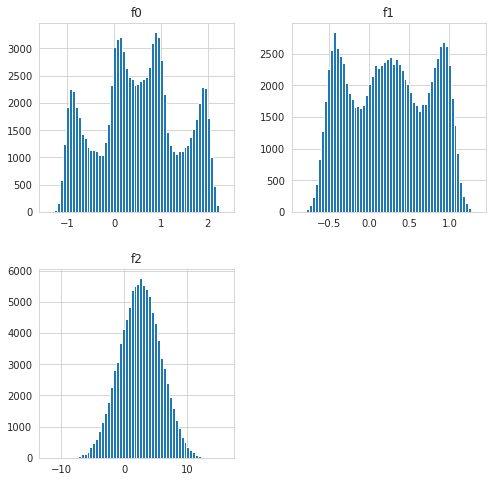

In [40]:
print('Распределение признаков:') 
df1[['f0', 'f1', 'f2']].hist(bins=60, figsize=(8, 8));

#### 2-й регион

In [41]:
df2.sample(5)

,id,f0,f1,f2,product
9216,37SA5,-3.758629,-2.692676,3.004371,84.038886
16646,ArsRz,11.217639,7.763019,4.999400,134.766305
63677,BwLIp,-0.713773,-9.031463,3.007402,80.859783
3670,8cPWH,14.538096,-4.030961,1.008090,26.953261
91325,62RQ1,0.752213,-0.284724,3.000750,80.859783


In [42]:
describe_my_data(df2)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество явных дубликатов - 0

Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов в столбце id: 4

Коэффициенты корреляции:
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000



In [43]:
df2 = df2.drop_duplicates('id')
df2.id.duplicated().sum()

0

Распределение признаков:


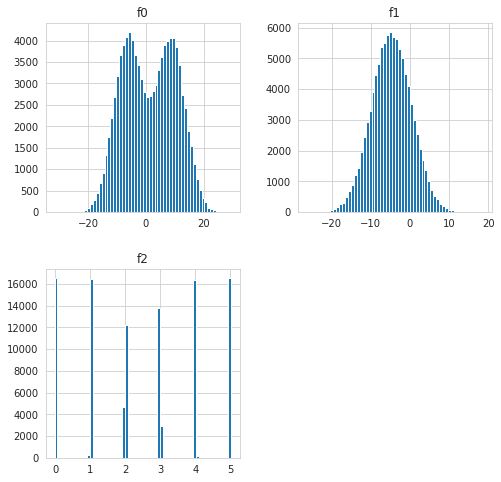

In [44]:
print('Распределение признаков:') 
df2[['f0', 'f1', 'f2']].hist(bins=60, figsize=(8, 8));

#### 3-й регион

In [45]:
df3.sample(5)

,id,f0,f1,f2,product
21704,vz9xT,-1.678578,0.616919,1.864063,73.034057
65911,YTzsk,-3.198291,-0.331014,6.985573,159.084294
37295,kE3t6,0.316081,-3.751015,3.544914,99.005725
95458,zmsiA,-3.710950,-2.003003,7.926818,168.548862
70617,CmXYC,-1.199063,-0.863978,3.244391,59.215510


In [46]:
describe_my_data(df3)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество явных дубликатов - 0

Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов в столбце id: 4

Коэффициенты корреляции:
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000



In [47]:
df3 = df3.drop_duplicates('id')
df3.id.duplicated().sum()

0

Распределение признаков:


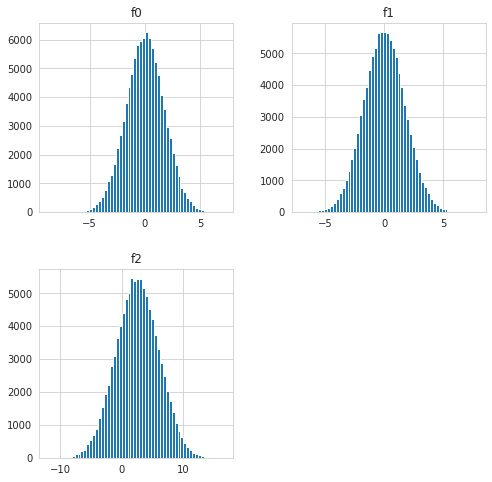

In [48]:
print('Распределение признаков:') 
df3[['f0', 'f1', 'f2']].hist(bins=60, figsize=(8, 8));

Вывод: Во всех датафреймах пропусков и дубликатов нет, с типами все в порядке, отсутствуют коллинеарные признаки. Везде присутствуют строки с нулями в целевом признаки, но я бы не стал удалять эти строки, так как непонятно почему появился ноль - может быть ошибка или данные не выгрузились, а возможно существует какая-то зависимость. Отдельно стоит обратить внимание на второй датафрейм - в нем есть сильная корреляция между целевым признаком и признаком f2, да и распределение этого признака очень странное и не похоже на остальные. Я бы поступил следующим образом: оставил второй датафрейм без изменений, создал бы копию датафрейма без этого признака и посмотрел бы как работает модель с ним.

In [49]:
df2_without_f2 = df2.drop(columns='f2')
df2_without_f2.sample(5)

,id,f0,f1,product
1034,vswvy,-9.557759,-12.123658,57.085625
67593,CgE4h,-4.993137,-0.782434,137.945408
9122,yja9u,13.969423,1.070348,107.813044
13318,v8tCX,-0.803622,-8.375301,57.085625
86292,X2GUU,-8.654321,-6.322022,84.038886


## Подготовка к расчёту прибыли

Определим функцию для предсказания прибиыли. Метрикой качества выберем RMSE.

In [50]:
def data_analyze(data):
    
    features = features = data.drop(columns=['id', 'product'])
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=0)
    scaler = MinMaxScaler()
    scaler.fit(features_train)
    features_train = pd.DataFrame(scaler.transform(features_train))
    features_valid = pd.DataFrame(scaler.transform(features_valid))

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    mean = predictions.mean()
    
    print(f'RMSE модели {rmse:.5}')
    print(f'Средний запас предсказанного сырья {mean:.5} тыс. баррелей')

    data = pd.DataFrame({'product_target':target_valid, 'product_predicted':predictions})
    return data['product_target'], data['product_predicted']

### 1-й регион

In [51]:
target_valid_1, predictions_1 = data_analyze(df1)

RMSE модели 37.726
Средний запас предсказанного сырья 92.696 тыс. баррелей


### 2-й регион

In [52]:
target_valid_2, predictions_2 = data_analyze(df2)

RMSE модели 0.88615
Средний запас предсказанного сырья 69.294 тыс. баррелей


In [53]:
target_valid_2_without_f2, predictions_2_without_f2 = data_analyze(df2_without_f2)

RMSE модели 46.056
Средний запас предсказанного сырья 68.674 тыс. баррелей


### 3-й регион

In [54]:
target_valid_3, predictions_3 = data_analyze(df3);

RMSE модели 40.185
Средний запас предсказанного сырья 95.141 тыс. баррелей


Вывод: Средняя квадратичная ошибка оказалась меньше всего у модели, обученной на 1 датафрейме, эта же локация занимает 2 место по среднему количеству предсказанного сырья. Стоит отметить ошибку модели второго региона с признаком f2 - она очень маленькая, что вызывает подозрение, это произошло из-за сильной корреляции между признаками. В дальнейшем для расчета прибыли будем использовать данные со столбцом f2 во втором регионе. Как будет видно, дальше при расчете минимального количества нефти на регион для окупаемости, все три региона подходят для добычи.

## Расчёт прибыли и рисков 

In [55]:
BUDGET = 10e+9 
PRICE_PER_BARREL = 450000
BEST_POINTS = 200
POINTS = 500
NUMBER_OF_WELLS = 100000

In [56]:
sufficient_volume = BUDGET / PRICE_PER_BARREL / 1000
print(f'Примерно {sufficient_volume:.3} тыс. баррелей в регионе нужно для окупаемости')
print(f'Это соответсвует {sufficient_volume/BEST_POINTS * 1000:.5} баррелей на скважину')

Примерно 22.2 тыс. баррелей в регионе нужно для окупаемости
Это соответсвует 111.11 баррелей на скважину


In [57]:
i = 1
for data in (df1, df2, df3):
    print(f'Средний объем на одну скважину в регионе {i} составляет {data["product"].mean()}')
    i += 1

Средний объем на одну скважину в регионе 1 составляет 92.49968421774354
Средний объем на одну скважину в регионе 2 составляет 68.82391591804064
Средний объем на одну скважину в регионе 3 составляет 94.99834211933378


Функция для нахождения 500 лучших точек:

In [58]:
def find_best_points(predictions, target, count=BEST_POINTS):
    probs = predictions.sort_values(ascending=False)
    selected = target[probs.index][:count]
    return PRICE_PER_BARREL * selected.sum() - BUDGET 

Бутстрап:

In [59]:
def bootstrap(predictions, target, n=1000):
    state = np.random.RandomState(0)
    profit = []
    loss = 0
    
    for _ in range(n):
        target_sample = target.sample(n=POINTS, replace=True, random_state=state)
        probs_sample = predictions[target_sample.index]
        predicted_profit = find_best_points(probs_sample, target_sample)
        profit.append(predicted_profit)
        if predicted_profit < 0:
            loss +=1     
    profit = pd.Series(profit)
    confidence_interval = st.t.interval(confidence=0.95, df=len(profit)-1, loc=profit.mean(), scale=profit.sem())
    
    print (f'С вероятностью 95% средняя выручка {profit.mean()/1e+6:.5} млн. рублей находится в интервале от {confidence_interval[0]/1e+6:.5} до {confidence_interval[1]/1e+6:.5} млн. рублей')
    print(f'95% доверительный интервал распределения прибыли находится от {profit.quantile(0.0251)/1e+6:.5} до {profit.quantile(0.975)/1e+6:.5} млн. рублей')
    print(f'Риски составили {loss/n:.1%}', end='\n\n')
    sns.set_style("whitegrid")
    print('Распределние выручки:')
    sns.histplot(x=profit, bins=100, legend=True)
    plt.axvline(confidence_interval[0], color='r')
    plt.axvline(confidence_interval[1], color='r')

### 1-й регион

С вероятностью 95% средняя выручка 472.58 млн. рублей находится в интервале от 455.62 до 489.53 млн. рублей
95% доверительный интервал распределения прибыли находится от -69.808 до 1018.2 млн. рублей
Риски составили 4.4%

Распределние выручки:


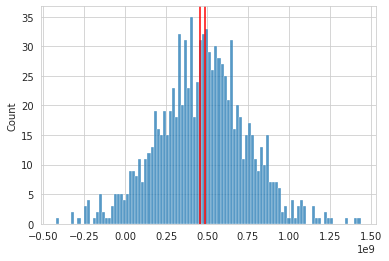

In [60]:
bootstrap(predictions_1, target_valid_1);

### 2-й регион

С вероятностью 95% средняя выручка 555.7 млн. рублей находится в интервале от 542.69 до 568.71 млн. рублей
95% доверительный интервал распределения прибыли находится от 169.59 до 991.46 млн. рублей
Риски составили 0.3%

Распределние выручки:


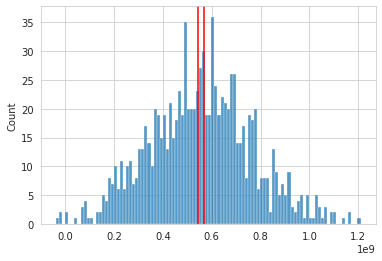

In [61]:
bootstrap(predictions_2, target_valid_2);

### 3-й регион

С вероятностью 95% средняя выручка 364.73 млн. рублей находится в интервале от 347.57 до 381.88 млн. рублей
95% доверительный интервал распределения прибыли находится от -160.02 до 933.9 млн. рублей
Риски составили 9.7%

Распределние выручки:


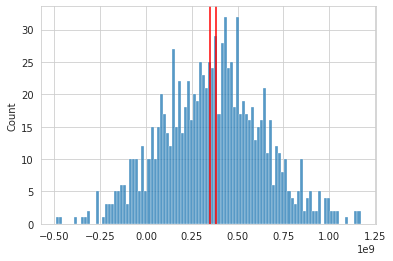

In [62]:
bootstrap(predictions_3, target_valid_3);

## Вывод

Среди всех регионов второй является наиболее привлекательным для добычи как по средней выручке, которая составляет 555.7 млн. рублей, так и по рискам неокупаемости, которые составляют 0.3%. На втором месте расположился первый регион со средней выручкой 472.58 млн. рублей и риском неокупаемости 4.4%. На последнем месте третий регион с выручкой 364.73 млн. рублей и риском неокупаемости 9.7%.